## m6A

In [26]:
import pandas as pd
from subprocess import call
import os

os.chdir("/mnt/hpc/home/xuxinran/DirectSeq/9_image_of_graduation/1")
df = pd.read_csv("/mnt/hpc/home/xuxinran/DirectSeq/data/zhaolin_240206/240201-zhaolin-RNA-merge/v0.8.1/m6Aqtl/nano_merge_m6A_sites.csv")


In [4]:
# 1、m6A在HEK293T细胞中广泛存在，约87%的基因都带有m6A修饰。
m6A_bed = df.copy()
m6A_bed['s'] = m6A_bed['pos_1base'] - 1
m6A_bed['e'] = m6A_bed['pos_1base'] + 1
m6A_bed['score'] = 0
m6A_bed = m6A_bed[['chrom', 's', 'e', 'pos_1base', 'score', 'strand']]
m6A_bed.to_csv("m6A.bed", sep="\t", header=False, index=False)

gff_df = pd.read_csv("/mnt/hpc/home/xuxinran/REF/hg19/gencode.v47lift37.annotation.gff3.gz",usecols = [0,2,3,4,5,6,8],header=None, names=['chrom', 'type', 's', 'e', 'name', 'strand','info'], sep="\t", comment="#")
gff_df = gff_df[gff_df["type"] == "gene"]
gff_df['score'] = 0
gff_df['gene_id'] = gff_df['info'].apply(lambda x: x.split("gene_id=")[1].split(";")[0])
gff_df = gff_df.loc[:, ['chrom', 's', 'e', 'gene_id', 'score', 'strand']]
gff_df.to_csv("gff.bed",header=None,sep = "\t", index=None)

call('bedtools intersect -a m6A.bed -b gff.bed -wa -wb -s > m6A_gene_overlap.txt',shell=True)

res_df = pd.read_csv("m6A_gene_overlap.txt", sep="\t", header=None,usecols=[0,3,5,9],names=["chrom","pos","strand","gene"])
# gene数量80311
unique_genes = res_df['gene'].unique()
unique_count = len(unique_genes)
unique_count/80311

0.20688324139906114

In [25]:
# 2、在带有m6A修饰的基因中，大多数（86%）都包含多个m6A位点，平均每个基因约有10个m6A位点。

gene_counts = res_df['gene'].value_counts()
# 筛选出现次数不为 1 的基因
non_one_counts = gene_counts[gene_counts != 1]

# 计算出现次数不为 1 的基因数量
non_one_count = len(non_one_counts)

# 计算出现次数不为 1 的基因的平均出现次数
non_one_average = non_one_counts.mean()

print(non_one_count/unique_count,non_one_average)

0.9523322299127295 29.81248815016116


In [ ]:
# 3、一些基因（如SPEN、BSN和ALMS1）的成熟mRNA转录本包含超过100个m6A修饰位点。
gene_counts

# ENSG00000204956 PCDHGA1
# ENSG00000254245 PCDHGA3
# ENSG00000254221 PCDHGB1

gene
ENSG00000291336.1_1     414
ENSG00000291338.1_1     366
ENSG00000204956.6_7     308
ENSG00000254245.3_7     308
ENSG00000254221.3_7     308
                       ... 
ENSG00000301077.1_1       1
ENSG00000229474.8_18      1
ENSG00000197360.9_12      1
ENSG00000252558.1         1
ENSG00000264063.1         1
Name: count, Length: 16615, dtype: int64

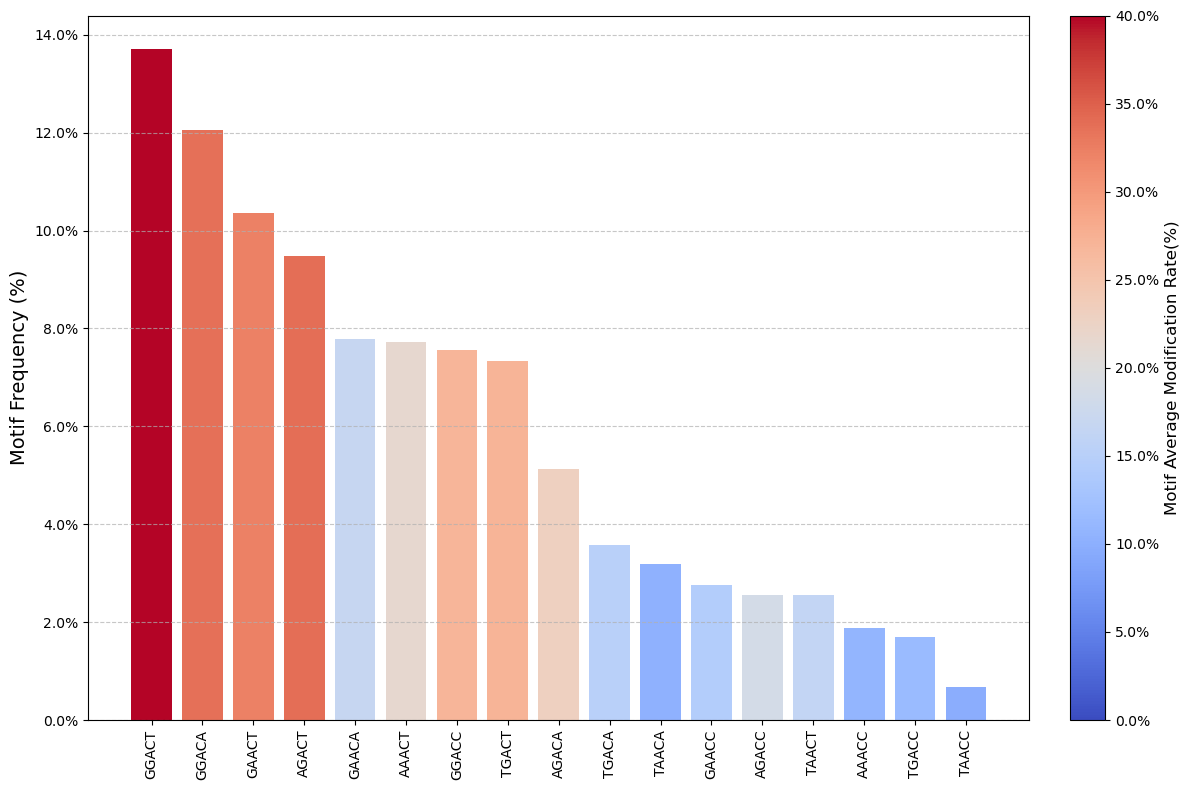

统计数据概览 (频率和修饰率均以百分比表示):
    motif  count  frequency  median_methy_rate  \
10  GGACT  30413      13.71              24.79   
8   GGACA  26762      12.06              18.00   
7   GAACT  22974      10.36              16.90   
4   AGACT  21028       9.48              18.26   
5   GAACA  17269       7.78               9.09   
1   AAACT  17156       7.73              11.11   
9   GGACC  16762       7.56              14.29   
16  TGACT  16256       7.33              14.29   
2   AGACA  11357       5.12              12.50   
14  TGACA   7929       3.57               8.70   
11  TAACA   7053       3.18               6.89   
6   GAACC   6115       2.76               8.70   
3   AGACC   5685       2.56              10.00   
13  TAACT   5676       2.56               9.09   
0   AAACC   4183       1.89               7.14   
15  TGACC   3762       1.70               7.41   
12  TAACC   1481       0.67               6.67   

    Motif Average Modification Rate(%)  
10                               4

In [31]:
# 4、RRACH基序是最常见的，并且其甲基化水平也较高。(motif的频率、频率对应的甲基化速度)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mtick

# 计算每个motif的频率和常规修饰率统计
df = df[df['motif'] != 'AAACA']
df = df[df['methy_rate']>4]
motif_stats = df.groupby('motif').agg(
    count=('motif', 'count'),
    median_methy_rate=('methy_rate', 'median')
).reset_index()

# 计算25%-100%区间的平均值
def upper_quartile_mean(x):
    q1 = np.percentile(x, 25)
    upper_values = x[x >= q1]
    return np.mean(upper_values) if len(upper_values) > 0 else np.nan

# 添加25%-100%平均值到统计数据中
upper_means = df.groupby('motif')['methy_rate'].apply(upper_quartile_mean)
motif_stats['upper_quartile_mean'] = motif_stats['motif'].map(upper_means)

# 计算motif频率并转换为百分比
total_sites = len(df)
motif_stats['frequency'] = motif_stats['count'] / total_sites * 100

# 按频率排序
motif_stats = motif_stats.sort_values('frequency', ascending=False)

# 创建自定义色彩映射：从低修饰率(蓝色)到高修饰率(红色)
colors = plt.cm.coolwarm(np.linspace(0, 1, 256))
custom_cmap = LinearSegmentedColormap.from_list('custom_coolwarm', colors)

# 创建图形和轴对象
fig, ax = plt.subplots(figsize=(12, 8))

# 使用25%-100%区间平均修饰率进行归一化
max_methy_rate = 40  # 设置最大修饰率为30%
norm_methy_rates = motif_stats['upper_quartile_mean'] / max_methy_rate
# 确保归一化值不超过1
norm_methy_rates = np.clip(norm_methy_rates, 0, 1)

# 创建柱状图
bars = ax.bar(
    motif_stats['motif'],
    motif_stats['frequency'],
    color=custom_cmap(norm_methy_rates)
)

# 添加标题和标签
# ax.set_title('Motif频率与甲基化修饰率', fontsize=16, fontweight='bold')
# ax.set_xlabel('Motif', fontsize=14)
ax.set_ylabel('Motif Frequency (%)', fontsize=14)

# 设置垂直的x轴标签
plt.xticks(rotation=90)

# 设置y轴显示为百分比格式
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))

# 添加颜色条，用于表示修饰率（百分比格式，范围0-30%）
norm = plt.Normalize(0, max_methy_rate)
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])

# 创建更精致的颜色条
cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Motif Average Modification Rate(%)', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# 为颜色条添加百分比格式
cbar.ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# 增加网格线以提高可读性
ax.grid(axis='y', linestyle='--', alpha=0.7)

# 调整布局
plt.tight_layout()

# 保存图片
plt.savefig('m6A_motif_methylation_plot.pdf', dpi=300, bbox_inches='tight')

# 显示图形
plt.show()

# 输出统计数据以供参考（频率和修饰率都以百分比形式显示）
print("统计数据概览 (频率和修饰率均以百分比表示):")
summary_df = motif_stats[['motif', 'count', 'frequency', 'median_methy_rate', 'upper_quartile_mean']]
summary_df = summary_df.rename(columns={
    'upper_quartile_mean': 'Motif Average Modification Rate(%)'
})
print(summary_df.round(2))


In [32]:
## 5、修饰率的中位数
Q1 = df['methy_rate'].quantile(0.25)  # 第一四分位数（25%）
Q2 = df['methy_rate'].quantile(0.50)  # 第二四分位数（50%），即中位数
Q3 = df['methy_rate'].quantile(0.75)  # 第三四分位数（75%）

print(f"第一四分位数 (Q1): {Q1}")
print(f"第二四分位数 (Q2): {Q2}")
print(f"第三四分位数 (Q3): {Q3}")

第一四分位数 (Q1): 6.98
第二四分位数 (Q2): 13.19
第三四分位数 (Q3): 29.29


## pseU

In [34]:
## 1、平均修饰率
df = pd.read_csv("/mnt/hpc/home/xuxinran/DirectSeq/data/zhaolin_240206/240201-zhaolin-RNA-merge/v0.8.1/pseUqtl/nano_merge_pseU_sites.csv")

df = df[df['mod_rate']>10]
Q1 = df['mod_rate'].quantile(0.25)  # 第一四分位数（25%）
Q2 = df['mod_rate'].quantile(0.50)  # 第二四分位数（50%），即中位数
Q3 = df['mod_rate'].quantile(0.75)  # 第三四分位数（75%）

print(f"第一四分位数 (Q1): {Q1}")
print(f"第二四分位数 (Q2): {Q2}")
print(f"第三四分位数 (Q3): {Q3}")


第一四分位数 (Q1): 12.5
第二四分位数 (Q2): 14.29
第三四分位数 (Q3): 19.05


In [12]:
## 2、m6A在HEK293T细胞中广泛存在，约87%的基因都带有m6A修饰。
pseU_bed = df.copy()
pseU_bed['s'] = pseU_bed['pos_1base'] - 1
pseU_bed['e'] = pseU_bed['pos_1base'] + 1
pseU_bed['score'] = 0
pseU_bed = pseU_bed[['chrom', 's', 'e', 'pos_1base', 'score', 'strand']]
pseU_bed.to_csv("pseU.bed", sep="\t", header=False, index=False)

gff_df = pd.read_csv("/mnt/hpc/home/xuxinran/REF/hg19/gencode.v47lift37.annotation.gff3.gz",usecols = [0,2,3,4,5,6,8],header=None, names=['chrom', 'type', 's', 'e', 'name', 'strand','info'], sep="\t", comment="#")
gff_df = gff_df[gff_df["type"] == "gene"]
gff_df['score'] = 0
gff_df['gene_id'] = gff_df['info'].apply(lambda x: x.split("gene_id=")[1].split(";")[0])
gff_df = gff_df.loc[:, ['chrom', 's', 'e', 'gene_id', 'score', 'strand']]
gff_df.to_csv("gff.bed",header=None,sep = "\t", index=None)

call('bedtools intersect -a pseU.bed -b gff.bed -wa -wb -s > pseU_gene_overlap.txt',shell=True)

res_df = pd.read_csv("pseU_gene_overlap.txt", sep="\t", header=None,usecols=[0,3,5,9],names=["chrom","pos","strand","gene"])
# gene数量80311
unique_genes = res_df['gene'].unique()
unique_count = len(unique_genes)
unique_count/80311

0.2063104680554345

In [ ]:
## 3、在带有m6A修饰的基因中，大多数（86%）都包含多个m6A位点，平均每个基因约有10个m6A位点。
gene_counts = res_df['gene'].value_counts()
# 筛选出现次数不为 1 的基因
non_one_counts = gene_counts[gene_counts != 1]

# 计算出现次数不为 1 的基因数量
non_one_count = len(non_one_counts)

# 计算出现次数不为 1 的基因的平均出现次数
non_one_average = non_one_counts.mean()

print(non_one_count/unique_count,non_one_average)

0.9514152936206168 46.39869322506978


In [ ]:
# 4、一些基因（如SPEN、BSN和ALMS1）的成熟mRNA转录本包含超过100个m6A修饰位点。
gene_counts

# ENSG00000224078 SNHG14
# ENSG00000076356 PLXNA2
# ENSG00000197535 MYO5A

gene
ENSG00000291336.1_1      518
ENSG00000291338.1_1      458
ENSG00000224078.16_10    325
ENSG00000076356.7_9      317
ENSG00000197535.16_18    312
                        ... 
ENSG00000143226.16_16      1
ENSG00000117472.10_7       1
ENSG00000227857.3_9        1
ENSG00000289407.2_2        1
ENSG00000206417.9_10       1
Name: count, Length: 16569, dtype: int64

In [36]:
## 5、motif对应的数量
df['motif_len'] = df['motif'].str.len()
print(df['motif_len'].value_counts())

motif_len
3    61137
5     1041
6      397
Name: count, dtype: int64


/tmp/ipykernel_22184/565002410.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['motif_len'] = df_filtered['motif_len'].astype('category')
/tmp/ipykernel_22184/565002410.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


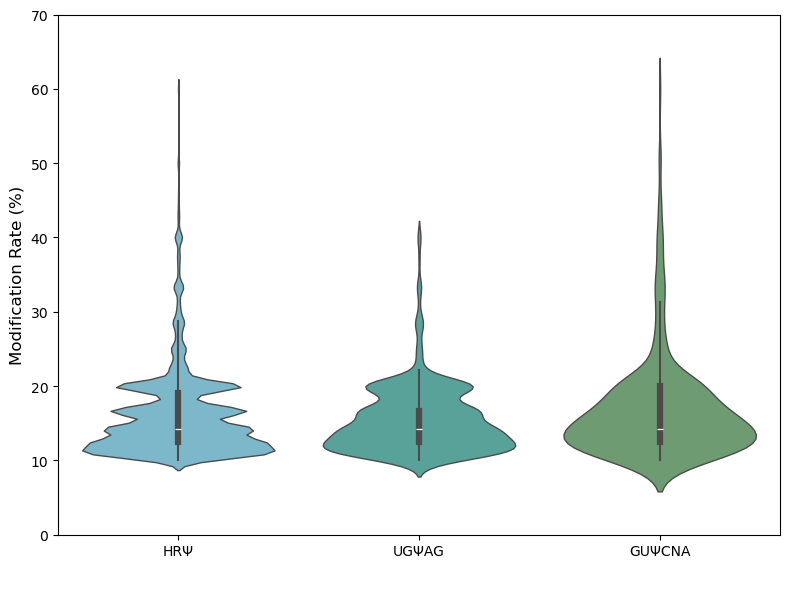

In [ ]:
## 6、motif对应的修饰率小提琴图

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 df 是您的 DataFrame，'motif_len' 和 'mod_rate' 是您要使用的列

# 移除超出范围的数据点
df_filtered = df[df['mod_rate'] <= 60]

# 将 motif_len 列转换为分类数据
df_filtered['motif_len'] = df_filtered['motif_len'].astype('category')

# 自定义颜色设置，从左到右分别是70bed7、4daea4、67a26c
custom_colors = ['#70bed7', '#4daea4', '#67a26c']

# 绘制小提琴图，设置width=0.8增加宽度
plt.figure(figsize=(8, 6))
sns.violinplot(
    x='motif_len', 
    y='mod_rate', 
    data=df_filtered, 
    width=0.8,  # 增加宽度，原来是0.6
    palette=custom_colors,  # 自定义颜色
    inner='box',  # 使用box样式便于自定义
    linewidth=1
)

# 设置内部四分位数标记为白色，背景为黑色
for patch in plt.gca().collections:
    if isinstance(patch, plt.matplotlib.collections.PolyCollection):
        # 这些是小提琴的主体
        continue
    # 这些是内部的四分位数标记
    patch.set_edgecolor('white')  # 四分位数标记的边缘为白色
    patch.set_facecolor('black')  # 四分位数标记的填充为黑色

# 设置纵坐标范围
plt.ylim(0, 70)
plt.xticks([0, 1, 2], ['HRΨ', 'UGΨAG', 'GUΨCNA'])
# 添加标题和标签
# plt.title('Mod Rate vs Motif Length', fontsize=14)
plt.xlabel(' ', fontsize=12)
plt.ylabel('Modification Rate (%)', fontsize=12)

plt.savefig('pseU_motif_methylation_plot.pdf', dpi=300, bbox_inches='tight')

# 显示图形
plt.tight_layout()
plt.show()


In [ ]:
## 7、讲解小提琴图

import pandas as pd

def get_motif_stats(df, motif_col='motif_len', mod_rate_col='mod_rate'):
    """
    获取不同 motif 的数量、修饰率四分位数和最大值。

    参数：
        df (pd.DataFrame): 包含 motif 和修饰率的 DataFrame。
        motif_col (str): motif 列的名称。
        mod_rate_col (str): 修饰率列的名称。

    返回：
        pd.DataFrame: 包含 motif 统计信息的 DataFrame。
    """

    motif_stats = df.groupby(motif_col).agg(
        count=(mod_rate_col, 'count'),
        q1=(mod_rate_col, lambda x: x.quantile(0.25)),
        median=(mod_rate_col, 'median'),
        q3=(mod_rate_col, lambda x: x.quantile(0.75)),
        max=(mod_rate_col, 'max')
    )

    return motif_stats

# 假设 df 是您的 DataFrame

motif_stats_df = get_motif_stats(df)

print(motif_stats_df)

/tmp/ipykernel_22184/3164627542.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  motif_stats = df.groupby(motif_col).agg(


           count    q1  median     q3    max
motif_len                                   
3          61137  12.5   14.29  19.05  100.0
5           1041  12.5   14.29  16.67   40.0
6            397  12.5   14.29  20.00   60.0


## m5C

In [56]:
## 1、平均修饰率
df = pd.read_csv("/mnt/hpc/home/xuxinran/DirectSeq/data/zhaolin_240206/240201-zhaolin-RNA-merge/v0.8.1/m5Cqtl/nano_merge_m5C_sites.csv")

df = df[df['methy_rate']>4]
Q1 = df['methy_rate'].quantile(0.25)  # 第一四分位数（25%）
Q2 = df['methy_rate'].quantile(0.50)  # 第二四分位数（50%），即中位数
Q3 = df['methy_rate'].quantile(0.75)  # 第三四分位数（75%）

print(f"第一四分位数 (Q1): {Q1}")
print(f"第二四分位数 (Q2): {Q2}")
print(f"第三四分位数 (Q3): {Q3}")


## 2、m6A在HEK293T细胞中广泛存在，约87%的基因都带有m6A修饰。
m5C_bed = df.copy()
m5C_bed['s'] = m5C_bed['pos_1base'] - 1
m5C_bed['e'] = m5C_bed['pos_1base'] + 1
m5C_bed['score'] = 0
m5C_bed = m5C_bed[['chrom', 's', 'e', 'pos_1base', 'score', 'strand']]
m5C_bed.to_csv("m5C.bed", sep="\t", header=False, index=False)

gff_df = pd.read_csv("/mnt/hpc/home/xuxinran/REF/hg19/gencode.v47lift37.annotation.gff3.gz",usecols = [0,2,3,4,5,6,8],header=None, names=['chrom', 'type', 's', 'e', 'name', 'strand','info'], sep="\t", comment="#")
gff_df = gff_df[gff_df["type"] == "gene"]
gff_df['score'] = 0
gff_df['gene_id'] = gff_df['info'].apply(lambda x: x.split("gene_id=")[1].split(";")[0])
gff_df = gff_df.loc[:, ['chrom', 's', 'e', 'gene_id', 'score', 'strand']]
gff_df.to_csv("gff.bed",header=None,sep = "\t", index=None)

call('bedtools intersect -a m5C.bed -b gff.bed -wa -wb -s > m5C_gene_overlap.txt',shell=True)

res_df = pd.read_csv("m5C_gene_overlap.txt", sep="\t", header=None,usecols=[0,3,5,9],names=["chrom","pos","strand","gene"])
# gene数量80311
unique_genes = res_df['gene'].unique()
unique_count = len(unique_genes)
print(unique_count/80311)

## 3、在带有m6A修饰的基因中，大多数（86%）都包含多个m6A位点，平均每个基因约有10个m6A位点。
gene_counts = res_df['gene'].value_counts()
# 筛选出现次数不为 1 的基因
non_one_counts = gene_counts[gene_counts != 1]

# 计算出现次数不为 1 的基因数量
non_one_count = len(non_one_counts)

# 计算出现次数不为 1 的基因的平均出现次数
non_one_average = non_one_counts.mean()

print(non_one_count/unique_count,non_one_average)


# 4、一些基因（如SPEN、BSN和ALMS1）的成熟mRNA转录本包含超过100个m6A修饰位点。
gene_counts

# ENSG00000224078 SNHG14
# ENSG00000076356 PLXNA2
# ENSG00000197535 MYO5A

第一四分位数 (Q1): 5.26
第二四分位数 (Q2): 7.14
第三四分位数 (Q3): 11.11
0.1993998331486347
0.9277507181216436 14.86228713737632


gene
ENSG00000291336.1_1      209
ENSG00000291338.1_1      192
ENSG00000142798.20_20    146
ENSG00000167291.16_18    118
ENSG00000130635.17_15    117
                        ... 
ENSG00000250999.3_12       1
ENSG00000188996.5_11       1
ENSG00000228793.4_12       1
ENSG00000212802.4_5        1
ENSG00000220875.1_6        1
Name: count, Length: 16014, dtype: int64

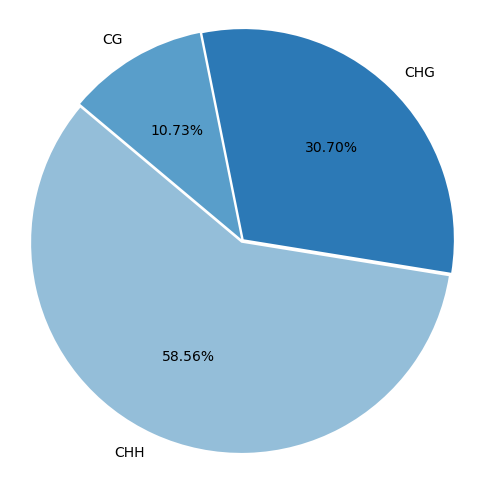

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设您的数据存储在名为 df 的 pandas DataFrame 中
# 且 'motif_classification' 列包含 motif 种类信息

motif_counts = df['motif_classification'].value_counts()
# 设置颜色
colors = ['#94bed9','#2c79b6','#599eca']
# 设置分离距离
explode = (0.01, 0.01, 0.01)  # 每个扇区分离 0.05

plt.figure(figsize=(6, 6))
plt.pie(motif_counts, labels=motif_counts.index, autopct='%1.2f%%', startangle=140, explode=explode, colors=colors)
# plt.title('Motif 种类分布 (分离式饼图)')
plt.savefig('m5C_motif_methylation_plot.pdf', dpi=300, bbox_inches='tight')
plt.axis('equal')
plt.show()